# <center> Systematic Trading Strategies with Machine Learning Algorithms </center>

## <center>Programming Session 6 - Introducing Variable Selection Networks
</center>
<center>
<table class="tfo-notebook-buttons" style="margin-left: auto; margin-right: auto;">
  <tr>
    <td style="text-align: center; vertical-align: middle;">
      <a target="_blank" href="https://hm-ai.github.io/Systematic_Trading_Strategies_with_Machine_Learning_Algorithms/">
        <img src="https://drive.google.com/uc?export=view&id=1hTIoxoea8RTLgKb1oE6_PFmtTNPGs5p4" height="50"/>
        <br>Course page
      </a>
    </td>
    <td style="text-align: center; vertical-align: middle;">
      <a target="_blank" href="https://colab.research.google.com/drive/1_wQoRnnKuuVVQvN-dhVUulgaJM7MQCXI?usp=sharing">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />
        <br>Run in Google Colab
      </a>
    </td>
  </tr>
</table>
</center>

# Introduction



This Programmong Session introduces the Variable Selection Network (VSN), a neural network architecture specifically designed to identify important features in complex datasets. We'll be using the same synthetic dataset from Programming Session 2, with the addition of categorical features that introduce more complexity and realism to our data.

The VSN architecture addresses a key limitation of standard neural networks: their lack of inherent feature importance interpretation. While tree-based models naturally provide feature importance metrics, neural networks typically require additional techniques to understand which features drive predictions.


![My GIF](https://drive.google.com/uc?id=1T1Il-U_g8X7CmN5qOO_Mhm_pRg7Ydo4Q)



Our notebook follows these key steps:

1. **Basic Models Comparison**:
   - First, we'll implement tree-based models (Random Forest) to establish a baseline for feature importance analysis using Mean Decrease in Impurity (MDI)
   - Next, we'll build a vanilla neural network and observe its limitations in determining feature importance

2. **Variable Selection Network (VSN)**:
   - We'll then implement the VSN architecture to introduce explicit feature importance mechanisms into our neural network
   - This approach allows us to determine feature importance directly from the network's learned parameters


This architecture enables neural networks to maintain their predictive power while gaining the interpretability typically associated with tree-based models.

Let's begin by exploring how we generate synthetic data with known feature importance that will serve as our ground truth for evaluation.

# Generating Synthetic Data

In [ ]:
# Data manipulation libraries
import numpy as np  # for numerical operations
import pandas as pd  # for dataframes
import os  # for operating system functions
import time  # for timing operations
import warnings  # for handling warnings

# Set random seed for reproducibility
np.random.seed(42)

# Visualization libraries
import matplotlib.pyplot as plt  # for creating plots
import seaborn as sns  # for enhanced visualizations

# Statistical libraries
from scipy.stats import spearmanr  # for correlation analysis

# Machine learning preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Machine learning metrics and evaluation
from sklearn.metrics import (
    mutual_info_score, silhouette_samples, silhouette_score,
    calinski_harabasz_score, davies_bouldin_score,
    accuracy_score, roc_auc_score, log_loss, classification_report
)
from sklearn.inspection import permutation_importance

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer, Input, Dense, Concatenate, Embedding,
    BatchNormalization, LayerNormalization, Dropout
)
from tensorflow.keras.metrics import AUC, Precision, Recall

### Generating and Visualizing a Linear Dataset

In [ ]:
def generate_correlated_dataset(n_samples=1000, n_clusters=3, features_per_cluster=5,
                              n_noise=5, n_cat_features=3, cat_cardinalities=[5, 3, 7],
                              correlation=0.8, cat_importance=0.5, noise_level=0.3,
                              random_state=42):
    """
    Generate a dataset with numerical and categorical features for classification.

    Parameters:
    -----------
    n_samples : int
        Number of samples (rows) in the dataset
    n_clusters : int
        Number of feature clusters to generate
    features_per_cluster : int
        Number of numerical features in each cluster (including one base feature)
    n_noise : int
        Number of random noise features to add
    n_cat_features : int
        Number of categorical features to generate
    cat_cardinalities : list
        List containing the number of categories for each categorical feature
    correlation : float
        Correlation coefficient between features in the same cluster (0-1)
    cat_importance : float
        Weight given to categorical features in target creation (0-1)
    noise_level : float
        Amount of noise added to target (0-1, lower = higher accuracy)
    random_state : int
        Seed for random number generation

    Returns:
    --------
    X_num : pandas DataFrame
        Numerical feature matrix
    X_cat : pandas DataFrame
        Categorical feature matrix
    y : pandas Series
        Binary target variable
    true_importance : dict
        Dictionary with true feature importance values
    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler

    np.random.seed(random_state)

    # Validate inputs
    if n_cat_features > 0 and len(cat_cardinalities) != n_cat_features:
        raise ValueError("Length of cat_cardinalities must match n_cat_features")

    # Print dataset configuration
    print(f"Generating dataset with:")
    print(f"- {n_samples} samples")
    print(f"- {n_clusters} clusters with {features_per_cluster} numerical features each")
    print(f"- {n_noise} noise features")
    print(f"- {n_cat_features} categorical features")
    print(f"- Base correlation: {correlation}")
    print(f"- Categorical importance: {cat_importance}")
    print(f"- Noise level: {noise_level} (lower = higher accuracy)")

    # Initialize dataframes
    X_num = pd.DataFrame()
    X_cat = pd.DataFrame()

    # Track cluster membership
    cluster_membership = {}

    # Generate numerical features
    for i in range(n_clusters):
        # Create base feature
        base_feature = f"Base_{i}"
        X_num[base_feature] = np.random.normal(0, 1, n_samples)
        cluster_membership[base_feature] = f"Cluster_{i}"

        # Create correlated features
        for j in range(1, features_per_cluster):
            feature_name = f"Corr_{i}_{j}"
            noise = np.random.normal(0, 1, n_samples)
            noise_scale = np.sqrt(1 - correlation**2)
            X_num[feature_name] = correlation * X_num[base_feature] + noise_scale * noise
            cluster_membership[feature_name] = f"Cluster_{i}"

    # Add noise features
    for i in range(n_noise):
        feature_name = f"Noise_{i}"
        X_num[feature_name] = np.random.normal(0, 1, n_samples)
        cluster_membership[feature_name] = "Noise"

    # Generate categorical features
    cat_mappings = []  # Save mappings for importance calculation

    for i in range(n_cat_features):
        # Choose which cluster this categorical feature relates to
        cluster_idx = i % n_clusters
        base_feature = f"Base_{cluster_idx}"
        cat_feature_name = f"Cat_{i}"

        # Get cardinality for this feature
        cardinality = cat_cardinalities[i]

        # Create categories based on base feature values
        base_values = X_num[base_feature].values

        # Make categories by binning base feature values
        categories = []
        bin_edges = np.linspace(-3, 3, cardinality + 1)  # Normal dist mostly within [-3, 3]

        # Assign each sample to a category
        for val in base_values:
            for bin_idx in range(len(bin_edges) - 1):
                if bin_edges[bin_idx] <= val < bin_edges[bin_idx + 1]:
                    categories.append(bin_idx)
                    break
            else:  # If value is outside bins
                categories.append(cardinality - 1)

        # Store categorical feature
        X_cat[cat_feature_name] = categories
        cluster_membership[cat_feature_name] = f"Cluster_{cluster_idx}"

        # Save mapping for importance calculation
        cat_mappings.append({
            'feature': cat_feature_name,
            'base_feature': base_feature,
            'cardinality': cardinality
        })

    # Create target variable
    y_value = np.zeros(n_samples)
    feature_importance = {}

    # Numerical features contribution to target
    num_weight = 1.0 - cat_importance
    for i in range(n_clusters):
        base_feature = f"Base_{i}"
        # Decreasing importance by cluster (first cluster most important)
        weight = num_weight * (1.0 / (i + 1))
        y_value += weight * X_num[base_feature]
        feature_importance[base_feature] = weight

    # Categorical features contribution to target
    if n_cat_features > 0:
        cat_weight = cat_importance / n_cat_features
        for i, mapping in enumerate(cat_mappings):
            cat_feature = mapping['feature']
            cardinality = mapping['cardinality']

            # Convert categories to normalized values [0, 1]
            cat_values = X_cat[cat_feature].values
            normalized_effect = cat_values / (cardinality - 1)

            # Add to target with weight that decreases by index
            weight = cat_weight * (1.0 - 0.2 * i)  # Slightly reduce importance for later cats
            y_value += weight * normalized_effect
            feature_importance[cat_feature] = weight

    # Add controlled noise to target
    noise = np.random.normal(0, noise_level, n_samples)
    y_value += noise

    # Create binary target (above/below median)
    y_binary = (y_value > np.median(y_value)).astype(int)
    y = pd.Series(y_binary, name="target")

    # Calculate importance for correlated features
    for feature, cluster in cluster_membership.items():
        if feature in feature_importance:
            continue  # Already calculated
        elif cluster == "Noise":
            feature_importance[feature] = 0.0
        else:
            # Derived features get importance based on correlation with base
            cluster_idx = int(cluster.split('_')[1])
            base_feature = f"Base_{cluster_idx}"
            base_importance = feature_importance.get(base_feature, 0)

            # Importance proportional to correlation with base
            corr = np.corrcoef(X_num[feature], X_num[base_feature])[0, 1]
            feature_importance[feature] = base_importance * abs(corr) * 0.5

    # Normalize feature importance to sum to 1
    total_importance = sum(feature_importance.values())
    for feature in feature_importance:
        feature_importance[feature] /= total_importance

    # Standardize numerical features
    scaler = StandardScaler()
    X_num_scaled = pd.DataFrame(
        scaler.fit_transform(X_num),
        columns=X_num.columns
    )

    # Convert categorical features to proper type
    for col in X_cat.columns:
        X_cat[col] = X_cat[col].astype('category')

    # Package importance information
    true_importance = {
        'feature': feature_importance
    }

    return X_num_scaled, X_cat, y, true_importance

In [ ]:
X_num, X_cat, y, true_importance = generate_correlated_dataset(
    noise_level=0.01,
    cat_importance=0.6
)

Generating dataset with:
- 1000 samples
- 3 clusters with 5 numerical features each
- 5 noise features
- 3 categorical features
- Base correlation: 0.8
- Categorical importance: 0.6
- Noise level: 0.01 (lower = higher accuracy)


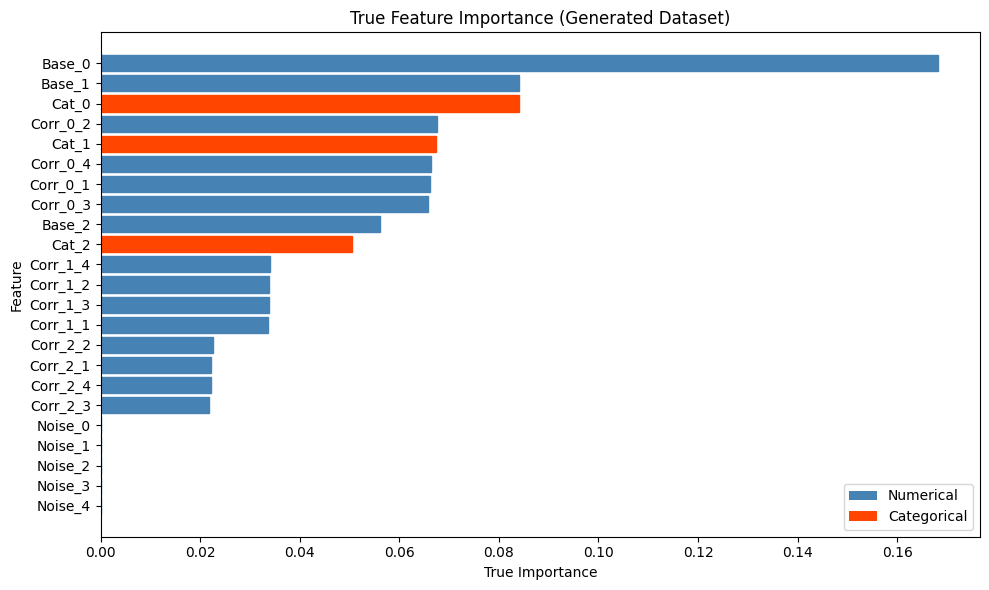

Top 10 Features by True Importance:
    Feature  True Importance         Type
0    Base_0         0.168222    Numerical
1    Base_1         0.084111    Numerical
3     Cat_0         0.084111  Categorical
7  Corr_0_2         0.067589    Numerical
4     Cat_1         0.067289  Categorical
9  Corr_0_4         0.066380    Numerical
6  Corr_0_1         0.066076    Numerical
8  Corr_0_3         0.065841    Numerical
2    Base_2         0.056074    Numerical
5     Cat_2         0.050467  Categorical


In [ ]:
# Visualize true feature importance
feature_imp_df = pd.DataFrame({
    'Feature': list(true_importance['feature'].keys()),
    'True Importance': list(true_importance['feature'].values()),
    'Type': ['Categorical' if f.startswith('Cat_') else 'Numerical' for f in true_importance['feature'].keys()]
}).sort_values('True Importance', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(feature_imp_df['Feature'], feature_imp_df['True Importance'])

# Color bars by feature type
for i, bar in enumerate(bars):
    if feature_imp_df.iloc[i]['Type'] == 'Categorical':
        bar.set_color('orangered')
    else:
        bar.set_color('steelblue')

plt.xlabel('True Importance')
plt.ylabel('Feature')
plt.title('True Feature Importance (Generated Dataset)')
plt.gca().invert_yaxis()  # Highest importance at top

# Add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Numerical'),
    Patch(facecolor='orangered', label='Categorical')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Print top features
print("Top 10 Features by True Importance:")
print(feature_imp_df.head(10))

---
<font color=green>Q1:</font> <br><font color='green'>
Split the dataset into training and testing sets with a test size of 20% and random state of 42. The dataset consists of:
- X_num: Numerical features (standardized continuous variables organized in clusters)
- X_cat: Categorical features (discrete variables correlated with base numerical features)
- y: Target variable (binary classification target)

Print the number of samples in each set to verify the split ratio.
</font>  

---


In [ ]:
# Split the data
X_num_train, X_num_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_num, X_cat, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(y_train)} samples")
print(f"Testing set size: {len(y_test)} samples")

Training set size: 800 samples
Testing set size: 200 samples


---
<font color=green>Q2:</font> <br><font color='green'>
Prepare the features for model training by:
1. One-hot encoding the categorical features in both `X_cat_train` and `X_cat_test` datasets
2. Combining numerical features (`X_num_train`/`X_num_test`) and encoded categorical features into unified matrices `X_train_combined` and `X_test_combined`
</font>  

---

In [ ]:
# One-hot encode categorical features
X_cat_train_encoded = pd.get_dummies(X_cat_train, drop_first=False)
X_cat_test_encoded = pd.get_dummies(X_cat_test, drop_first=False)

# Align the one-hot encoded columns (in case test set is missing some categories)
train_columns = X_cat_train_encoded.columns
for col in train_columns:
    if col not in X_cat_test_encoded.columns:
        X_cat_test_encoded[col] = 0
X_cat_test_encoded = X_cat_test_encoded[train_columns]

# Combine all features
X_train_combined = pd.concat([X_num_train, X_cat_train_encoded], axis=1)
X_test_combined = pd.concat([X_num_test, X_cat_test_encoded], axis=1)

print(f"Training data shape: {X_train_combined.shape}")
print(f"Testing data shape: {X_test_combined.shape}")


Training data shape: (800, 35)
Testing data shape: (200, 35)


<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/H7v5qZbBuiHvMbBu9">Click here to participate in the poll</a>👈👈</center>

# Tree based models and vanilla Neural Networks

### Tree based Models

---
<font color=green>Q3:</font> <br><font color='green'>
Train a Random Forest model and evaluate its performance.
</font>  

---

In [ ]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_combined)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9400

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        96
           1       0.94      0.94      0.94       104

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



---
<font color=green>Q4:</font> <br><font color='green'>
Analyze feature importance using Mean Decrease in Impurity (MDI) from the Random Forest model.
</font>  

---

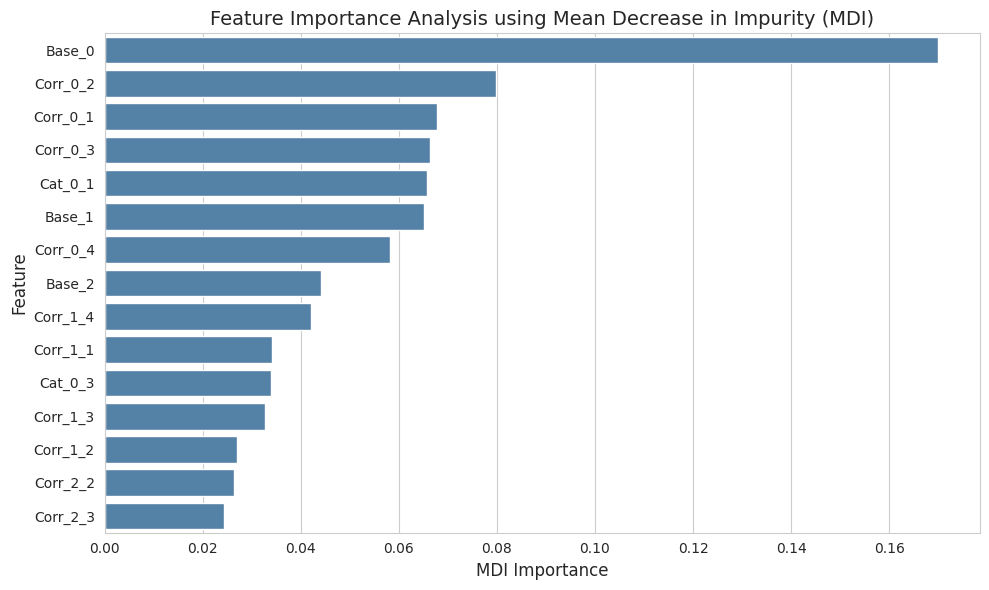

Top 10 Features by Importance:
     Feature  MDI_Importance
0     Base_0        0.170017
2   Corr_0_2        0.079800
1   Corr_0_1        0.067769
3   Corr_0_3        0.066389
21   Cat_0_1        0.065776
5     Base_1        0.065126
4   Corr_0_4        0.058231
10    Base_2        0.044173
9   Corr_1_4        0.042188
6   Corr_1_1        0.034218


In [ ]:
# Extract feature importance
importances = rf_model.feature_importances_
feature_names = X_train_combined.columns

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'MDI_Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('MDI_Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Show top 15 features for better readability
top_n = min(15, len(feature_importance_df))
top_features = feature_importance_df.head(top_n)

# Plot MDI importance
ax = sns.barplot(x='MDI_Importance', y='Feature', data=top_features, color='steelblue')

plt.title('Feature Importance Analysis using Mean Decrease in Impurity (MDI)', fontsize=14)
plt.xlabel('MDI Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Display the top 10 important features
print("Top 10 Features by Importance:")
print(feature_importance_df.head(10))

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/H7v5qZbBuiHvMbBu9">Click here to participate in the poll</a>👈👈</center>

### Neural Networks

---
<font color=green>Q5:</font> <br><font color='green'>
Implement a binary classification neural network that matches exactly the following architecture specifications:
- Input layer that accepts features with dimensions matching your training data
- First hidden layer with 128 neurons and ReLU activation
- Dropout layer with 0.3 rate
- Second hidden layer with 64 neurons and ReLU activation
- Another dropout layer with 0.3 rate
- Output layer with a single neuron and sigmoid activation
Use the Functional API approach rather than Sequential, and display the model summary after creation.
</font>  

---

<center><img width="600" src = "https://drive.google.com/uc?export=view&id=1p7mADAot9H7CyTOcrNBVEyHNme0zSoPn"></center>


In [ ]:
# Define input dimensions
input_dim = X_train_combined.shape[1]

# Step 1: Create the Neural Network using Functional API
# Define the input layer
inputs = Input(shape=(input_dim,))

# First hidden layer
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.3)(x)

# Second hidden layer
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
nn_model = Model(inputs=inputs, outputs=outputs)

# Model summary
nn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

---
<font color=green>Q6:</font> <br><font color='green'>
Compile the neural network with appropriate loss function for binary classification, Adam optimizer, and accuracy metric.
</font>  

---

<center><img width="600" src = "https://drive.google.com/uc?export=view&id=1n-F9nGIAvcrtbM4NGdHqkVKtxYjneuQe"></center>


**Optional Reading**: For those interested in the mathematical details behind the Adam optimizer's convergence properties, you can refer to:

[**Optional Lecture Notes**](https://drive.google.com/file/d/1sz7XPZfI-6zBKL7ZoSHYANu_lYp7GVrX/view?usp=sharing)

This supplementary material may provide deeper insights, but is not required for understanding the main course content.

In [ ]:
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully with binary crossentropy loss and accuracy metric.")

Model compiled successfully with binary crossentropy loss and accuracy metric.


---
<font color=green>Q7:</font> <br><font color='green'>
Train the neural network for 20 epochs with batch size of 32, using 20% of training data for validation. Include Dropout, callbacks for early stopping and learning rate reduction.
</font>  

---

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# Train the model
history = nn_model.fit(
    X_train_combined, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5968 - loss: 0.6477 - val_accuracy: 0.8500 - val_loss: 0.3807 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8882 - loss: 0.3308 - val_accuracy: 0.9062 - val_loss: 0.2505 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9165 - loss: 0.2497 - val_accuracy: 0.9187 - val_loss: 0.2077 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9090 - loss: 0.2024 - val_accuracy: 0.9062 - val_loss: 0.1878 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9007 - loss: 0.1960 - val_accuracy: 0.9187 - val_loss: 0.1707 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9339 - loss: 0.1570 - val_accuracy: 0.9312 - val_loss: 0.1576 - learning_rate: 0.0010
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9237 - loss: 0.1561 - val_accuracy:

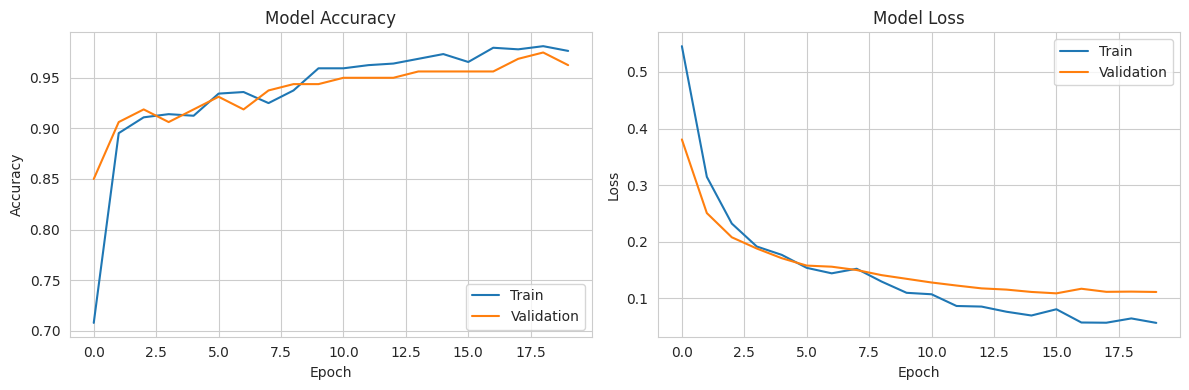

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/H7v5qZbBuiHvMbBu9">Click here to participate in the poll</a>👈👈</center>

# The Variable Selection Network

## Processing the Data

In [ ]:
# Calculate the cardinalities (number of unique values) for each categorical feature
cardinalities = []
for col in X_cat.columns:
    cardinality = X_cat[col].nunique()
    cardinalities.append(cardinality)

# Display information about categorical features and their cardinalities
cat_info = pd.DataFrame({
    'Feature': X_cat.columns,
    'Cardinality': cardinalities
})

print("Categorical feature cardinalities:")
print(cat_info)
print(f"\nCardinalities list: {cardinalities}")

# Display information about the split datasets
print(f"\nX_num_train shape: {X_num_train.shape}")
print(f"X_num_test shape: {X_num_test.shape}")
print(f"X_cat_train shape: {X_cat_train.shape}")
print(f"X_cat_test shape: {X_cat_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Categorical feature cardinalities:
  Feature  Cardinality
0   Cat_0            5
1   Cat_1            3
2   Cat_2            7

Cardinalities list: [5, 3, 7]

X_num_train shape: (800, 20)
X_num_test shape: (200, 20)
X_cat_train shape: (800, 3)
X_cat_test shape: (200, 3)
y_train shape: (800,)
y_test shape: (200,)


#### Introduction

We denote $x_i \in \mathbb{R}^D$ the D-dimensional vector representing all the processed features:

* The first $D_n$ dimensions are the numerical variables.
* The last $D_c$ dimensions are the label encoded categorical variables.


<center><img width="400" src = "https://drive.google.com/uc?export=view&id=1haI7b3oi60irjOv7W9iES99aUN1gPOMJ"></center>





Therefore, the first $D_n$ indices $d \in \{1, \dots, D_n\}$ are associated with the numerical variables $x_i^d$.

                                                     

Each categorical variable $x_i^{d'}$ of index $d'$ (where $d' \in \{D_n +1, \dots, D_n + D_c \}$) has $n_{d'}$ possible categories, as summarized in the following table:

| Categorical Variables | Cardinalities |
|-----------------------|---------------|
| Cat_0                 | 5             |
| Cat_1                 | 3             |
| Cat_2                 | 7             |

#### Encoding the numerical and the categorical variables into $D_e$-dimensional vectors

---
<font color=green>Q9:</font>
<br><font color='green'>
What is the primary limitation of Label Encoding ?
</font>

---

---
Label Encoding introduces an arbitrary ordering or importance in the categories. This might be fine in some cases like 'Low', 'Medium', 'High' where an order is implied, but for something like 'France', 'UK', 'Spain', this order has no meaning. In such cases, we often use another technique called One-Hot Encoding.

---

Let $D_e$ be the size of the embedding space. We would like to encode each feature (numerical or categorical) into a $D_e$-dimensional vector. To that end, we will use:

* **Dense Layers** for numerical features.

  Therefore, the numerical feature $x_i^d$ (for $d \in \{1, \dots, D_n\}$) will be mapped into a $D_e$-dimensional vector $\xi_i^d \in \mathbb{R}^{D_e}$.


* **Embedding Layers** for categorical features.

  The idea is to represent each category as a vector in a continuous vector space, rather than using one-hot encoding or Label Encoding. This has the advantage of capturing more complex relationships between categories, which can be especially important when dealing with categorical variables that have many categories. Therefore, the categorical feature $x_i^{d'}$ (for $d' \in \{D_n + 1, \dots, D_n + D_c\}$) will be mapped into a $D_e$-dimensional vector $\xi_i^{d'} \in \mathbb{R}^{D_e}$.

#### Example: Exploring one of the categorical variables `Cat_0`


Suppose $d'$ is the index of the categorical variable `Cat_0`, which has $n_{d'} = 5$ possible values, encoded into $\{0, 1, 2, 3, 4\}$ using Label Encoding.

Suppose we create an embedding layer (with the corresponding embedding_matrix $\mathcal{E}_{d'}$) to process the categorical variable `CAT_0`.




<center><img width="600" src = "https://drive.google.com/uc?export=view&id=1MO9QmTmZH9-A_Q29tF2xIjdte4jVd8kB"></center>


---
<font color=green>Q10:</font>
<br><font color='green'>
Explain why the embedding matrix $\mathcal{E}_{d'}$ associated with the categorical variable `Cat_0` is of shape $(n_{d'}, D_e$)

</font>

---

---
The embedding matrix has a shape of $(n_{d'}, D_e)$ because each row $i$ represents the embedding vector of the category label encoded into $i$.

As we have, $n_{d'}$ categories for `Cat_0`, we will have $n_{d'}$ rows in $\mathcal{E}_{d'}$.
As the embedding vectors are of size $D_e$, $\mathcal{E}_{d'}$ has $D_e$ columns.

---

These embedding vectors are learned during the training process and are updated via backpropagation, just like any other weights in the network

---
<font color=green>Q11:</font>
<br><font color='green'>
What would be the embedding vector associated with the category 2 of `Cat_1`?

</font>

---

---
It will be the row of index 2 of $\mathcal{E}_{d'}$.

---

#### Introducing the `InputTransformation` Layer

The following custom TensorFlow layer, named `InputTransformation`, is designed to process numerical and categorical features as described previously.

This layer takes as input the numerical tensor `X_num_train` $\in \mathbb{R}^{N_T \times D_n}$ and the categorical tensor `X_cat_train` $\in \mathbb{R}^{N_T \times D_c}$ and transforms them into a more representative space (embedded space) which can be further processed by downstream layers.


The `InputTransformation` class has several key attributes:

| Attribute  | Notation      | Description                                                              |
|-----------------|---------------|--------------------------------------------------------------------------|
| embedding_dim   |$D_e$ | Dimension of the space to which the input features will be mapped.             |                                                  
| num_numerical   | $D_n$           | Number of numerical features                                             |
| num_categorical | $D_c$           | Number of categorical features                                           |
| cardinalities   | cardinalities | List that contains the number of unique values (categories) for each categorical variable. |



In the `call` method, the class processes the numerical and categorical features separately.

* For each numerical feature, it applies a **Dense layer** (a linear operation with learnable weights and biases), which projects the numerical feature into the embedding space.
  
  Therefore, the numerical tensor  $\begin{bmatrix}
x_i^1 \\
\vdots\\
x_i^{D_n}\\
\end{bmatrix} \in \mathbb{R}^{D_n}$ is mapped into the list of tensors $\left[\xi_i^1 \in \mathbb{R}^{D_e}, \dots, \xi_i^d \in \mathbb{R}^{D_e}, \dots, \xi_i^{D_n} \in \mathbb{R}^{D_e} \right]$




* For each categorical feature, it applies an **Embedding layer**, which assigns each category an embedding vector in the embedding space.

  Therefore, the categorical tensor  $\begin{bmatrix}
x_i^{D_n+1} \\
\vdots\\
x_i^{D_n + D_c}\\
\end{bmatrix} \in \mathbb{R}^{D_c}$ is mapped into the list of tensors $\left[\xi_i^{D_n +1} \in \mathbb{R}^{D_e}, \dots, \xi_i^{d'} \in \mathbb{R}^{D_e}, \dots, \xi_i^{D_n + D_c} \in \mathbb{R}^{D_e} \right]$

* The following graph summarizes these transformations:

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1XGcCfnBVTvOR64kKWWQLMyOyg1CUfdTy"></center>


* Finally, it stacks all the embedded numerical features $\left[\xi_i^1 \in \mathbb{R}^{D_e}, \dots, \xi_i^d \in \mathbb{R}^{D_e}, \dots, \xi_i^{D_n} \in \mathbb{R}^{D_e} \right]$ and the embeded categorical features $\left[\xi_i^{D_n +1} \in \mathbb{R}^{D_e}, \dots, \xi_i^{d'} \in \mathbb{R}^{D_e}, \dots, \xi_i^{D_n + D_c} \in \mathbb{R}^{D_e} \right]$ along the last axis, resulting in the tensor $\left[\xi_i^1 \in \mathbb{R}^{D_e}, \dots, \xi_i^d \in \mathbb{R}^{D_e}, \dots, \xi_i^{D_n} \in \mathbb{R}^{D_e}, \xi_i^{D_n +1} \in \mathbb{R}^{D_e}, \dots, \xi_i^{d'} \in \mathbb{R}^{D_e}, \dots, \xi_i^{D_n + D_c} \in \mathbb{R}^{D_e} \right] \in \mathbb{R}^{D_e \times (D_n + D_c)}$ as shown in the following graph:

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1L-VOZBERHSgGLcc44pcYoCnbl7SIKkwa"></center>



In [ ]:
class InputTransformation(tf.keras.layers.Layer):
  def __init__(self, embedding_dim, num_numerical, num_categorical, cardinalities, **kwargs):
    super(InputTransformation, self).__init__(**kwargs)
    # Define the Hyperparameters
    self.embedding_dim = embedding_dim
    self.num_numerical = num_numerical
    self.num_categorical = num_categorical
    self.cardinalities = cardinalities

    # List of projections
    self.list_projection_layers = [Dense(self.embedding_dim) for _ in range(self.num_numerical)]
    # List of embedding layers
    self.list_embedding_layers = [Embedding(input_dim=cardinality, output_dim=self.embedding_dim)
                            for cardinality in self.cardinalities]

  def call(self, x_num, x_cat):
    """
    x_num (batch_size, num_numerical)
    x_cat (batch_size, num_categorical)
    """
    list_numerical_features = [] # list of num_numerical tensors[(batch_size, embedding_dim),...,(batch_size, embedding_dim)]
    # Apply the projections on each feature x_num[:, i:i+1]
    for i, projection in enumerate(self.list_projection_layers):
      list_numerical_features.append(projection(x_num[:, i:i+1]))
    list_categorical_features = [] # list of num_categorical tensors[(batch_size, embedding_dim),...,(batch_size, embedding_dim)]
    # Apply the Embedding layers on each categorical feature x_cat[:, i:i+1]
    for i, embedding_layer in enumerate(self.list_embedding_layers):
      list_categorical_features.append(embedding_layer(x_cat[:, i]))
    # stack all the embedding vectors (batch_size, embedding_dim, num_numerical + num_categorical)
    stack_features = tf.stack(list_numerical_features + list_categorical_features, axis=-1)
    return stack_features

---
<font color=green>Q12:</font>
<br><font color='green'>
Apply the layer on `X_num_train` and `X_cat_train` as follows by filling the following code with the appropriate values:
</font>

---

In [ ]:
# Create an instance of the InputTransformation
input_transformation = InputTransformation(
  embedding_dim = 32, # D_e = 32 or any value
  num_numerical = X_num_train.shape[1],
  num_categorical = X_cat_train.shape[1],
  cardinalities = cardinalities
)
# Apply it on the tensors X_num_train and X_cat_train as follows:
stack_features = input_transformation(X_num_train, X_cat_train)

# Print the shape of stack_features
print("The shape of stack_features is", stack_features.shape)

The shape of stack_features is (800, 32, 23)


---
<font color=green>Q13:</font>
<br><font color='green'>
Explain the shape of `stack_features`
</font>

---

---
stack_features is of shape $(N_T, D_e, D_n + D_C)$ as it represents $\left[\xi_i^1 \in \mathbb{R}^{D_e}, \dots, \xi_i^d \in \mathbb{R}^{D_e}, \dots, \xi_i^{D_n} \in \mathbb{R}^{D_e}, \xi_i^{D_n +1} \in \mathbb{R}^{D_e}, \dots, \xi_i^{d'} \in \mathbb{R}^{D_e}, \dots, \xi_i^{D_n + D_c} \in \mathbb{R}^{D_e} \right] \in \mathbb{R}^{D_e \times (D_n + D_c)}$ for each of the $N_T$ samples.

---

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/H7v5qZbBuiHvMbBu9">Click here to participate in the poll</a>👈👈</center>

## The Gated Residual Network

#### The Gated Linear Unit Layer



The following custom `GatedLinearUnits` (GLU) layer is a special kind of layer introduced in the paper [Language Modeling with Gated Convolutional Networks](https://arxiv.org/pdf/1612.08083.pdf). In general, the purpose of gating mechanisms is to control the flow of information in a neural network, and the Gated Linear Units follow this principle.

Here's how this custom TensorFlow layer works:

* The `GatedLinearUnits` class has the following attribute:

| Attribute  | Notation      | Description                                                              |
|-----------------|---------------|--------------------------------------------------------------------------|
| output_dim   | d_o             |   Dimension of the output vector                                               |




* **Initialization**: When the layer is instantiated, it takes an `output_dim` parameter, which defines the dimensionality of the output space of the layer.

* Two dense (fully connected) layers are also initialized: `dense_filter` and `dense_vector`. The `dense_filter` layer uses a **sigmoid** activation function, which will output values between 0 and 1, while `dense_vector` has no activation function specified, meaning it will use a linear activation function by default.

* In the `call` method, the input $\eta \in \mathbb{R}^{d_i}$ is processed by both `dense_filter` and `dense_vector`.

  * The input vector $\eta \in \mathbb{R}^{d_i}$ is processed by the `dense_filter` layer to get $\sigma \left( W_f^T \eta + b_f \right) \in \mathbb{R}^{d_o}$.
  
  * The input vector $\eta \in \mathbb{R}^{d_i}$ is also processed by the `dense_vector` layer to get $W^T \eta + b\in \mathbb{R}^{d_o}
$.
  * The output is the Hadamard product between both output vectors: $\sigma \left( W_f^T \eta + b_f \right) \circ \left(W^T \eta + b\right) \in \mathbb{R}^{d_o} $.

* The `GatedLinearUnit` layer is represented in the following graph:

<center><img width="900" src = "https://drive.google.com/uc?export=view&id=11h7MJpm8t9z7IT03QWbUgAiE53CVzJzd"></center>





In [ ]:
class GatedLinearUnits(tf.keras.layers.Layer):
  def __init__(self, output_dim, **kwargs):
    super(GatedLinearUnits, self).__init__(**kwargs)
    self.output_dim = output_dim
    self.dense_filter = Dense(output_dim, activation='sigmoid')
    self.dense_vector = Dense(output_dim)
  def call(self, x):
    filter = self.dense_filter(x)
    vector = self.dense_vector(x)
    output = tf.multiply(filter, vector)
    return output

---
<font color=green>Q14:</font>
<br><font color='green'>
Explain the intuition behind this gating mechanism.
</font>

---



---
Gating mechanism: The gating mechanism comes into play when the filter vector $\sigma \left( W_f^T \eta + b_f \right) \in \mathbb{R}^{d_o}$ and the vector
$\sigma \left( W_f^T \eta + b_f \right) \circ \left(W^T \eta + b\right) \in \mathbb{R}^{d_o} $ are element-wise multiplied using tf.multiply. Because the filter tensor only contains values between 0 and 1, it acts as a gate that controls the information flow from vector. If an element in filter is close to 0, the corresponding element in vector is mostly blocked (multiplied by a number close to 0). If an element in filter is close to 1, the corresponding element in vector is allowed to pass through (multiplied by a number close to 1).

---

---
<font color=green>Q15:</font>
<br><font color='green'>
What is the total number of parameters of the `GatedLinearUnit` layer as a function of $d_i$ and $d_o$ ?
</font>

---

---
* Each of the two dense layers has $d_i d_o + d_o$ parameters
* Therefore, the total number of parameters for the `GatedLinearUnit` layer is $2(d_i d_o + d_o)$

---

#### The Gated Residual Network

The following custom`GatedResidualNetwork` layer is a layer that implements a Gated Residual Network architecture, which is a type of feed-forward neural network that includes gating mechanisms and residual connections. This can be helpful in controlling the flow of information through the network and mitigating problems such as vanishing gradients.



* The input tensor $\xi$ is first passed through the two Dense layers and then through the Dropout layer. The first Dense layer applies an Exponential Linear Unit (ELU) activation function, and the second Dense layer has no activation function specified, meaning it will use a linear activation function by default. The Dropout layer randomly sets a fraction (10% in this case) of the input units to 0 at each update during training, which helps prevent overfitting.

* The output from the Dropout layer is passed through the `GatedLinearUnits` (GLU) layer described previously. This layer applies a gating mechanism that can help control the flow of information through the network.

* Then, the output from the GLU layer is added to the input tensor. This forms a residual connection, which can help alleviate the vanishing gradient problem and improve the ability of the network to learn complex patterns.

* Finally, the `LayerNormalization` layer is applied, which normalizes the output across the features (i.e., the last dimension) rather than across the batch. This can make the model more stable and faster to train.

* The following graph summarizes the different steps of processing an input vector $\xi \in \mathbb{R}^{d_i}$ into an output vector $\tilde{\xi} \in \mathbb{R}^{d_o}$ using the `GatedResidualNetwork`.

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1Kf0zZgyDvzBxFDqLc0nzOPXwzT4TGABb"></center>


In [ ]:
class GatedResidualNetwork(tf.keras.layers.Layer):
  def __init__(self, hidden_dim, output_dim, **kwargs):
    super(GatedResidualNetwork, self).__init__(**kwargs)
    self.hidden_dim=hidden_dim
    self.output_dim=output_dim
    # Define the layers
    self.projection = Dense(output_dim)
    self.dense_1 = Dense(hidden_dim, activation="elu")
    self.dense_2 = Dense(hidden_dim)
    self.dropout = Dropout(rate=0.1)
    self.glu = GatedLinearUnits(output_dim)
    self.layer_norm = LayerNormalization()

  def call(self, x):
    """
    x (batch_size, input_dim) -> output (batch_size, output_dim)
    """
    input_dim = x.shape[-1]
    z = self.dense_1(x) # (batch_size, hidden_dim)
    z = self.dense_2(z) # (batch_size, hidden_dim)
    z = self.dropout(z) # (batch_size, hidden_dim)
    z = self.glu(z) # (batch_size, output_dim)
    if input_dim != self.output_dim:
      x = self.projection(x)
    output = self.layer_norm(x + z) # (batch_size, output_dim)
    return output

#### Getting the final output vector

We would like to apply a Gated Residual Network (GRN) to each of the embedded features $\left[\xi_i^1, \dots, \xi_i^d , \dots, \xi_i^{D_n} , \xi_i^{D_n +1}, \dots, \xi_i^{d'}, \dots, \xi_i^{D_n + D_c} \right] \in \mathbb{R}^{D_e \times (D_n + D_c)}$ in order to get the following sequence of $D_o$-Dimensional vectors: $\left[\tilde{\xi}_i^1, \dots, \tilde{\xi}_i^d, \dots, \tilde{\xi}_i^{D_n}, \tilde{\xi}_i^{D_n +1}, \dots, \tilde{\xi}_i^{d'}, \dots, \tilde{\xi}_i^{D_n + D_c} \right] \in \mathbb{R}^{D_o \times (D_n + D_c)}$ as shown in the following graph:

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=15lm1HCVFM3365iMWsIVA-X0JZ9qm3puL"></center>

Let $\xi_i$ be the concatenation of all the vectors $\left[\xi_i^1, \dots,
\xi_i^d , \dots, \xi_i^{D_n} , \xi_i^{D_n +1}, \dots, \xi_i^{d'}, \dots, \xi_i^{D_n + D_c} \right]$.

---
<font color=green>Q16:</font>
<br><font color='green'>
What is the dimensionality of $\xi_i$ ?
</font>

---

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1L3hLN_9ljvKBo-NhYNlsRFtz-Jvl7B-P"></center>


Wa want to apply a `GatedResidualNetwork` and a `Softmax` activation function on the vector $\xi_i$ in order to get the vector $\alpha_i$ of size $D_n + D_c$ as shown in the following figure:

<center><img width="700" src = "https://drive.google.com/uc?export=view&id=1K3Ryx_M0lc9w8LUQdH6T7tuoJLStwVh3"></center>

---
<font color=green>Q17:</font>
<br><font color='green'>
Let $\psi_i$ be the output vector of the `GatedResidualNetwork` applied on $\xi_i$. How can we get $\alpha_i$ from $\psi_i$ ?

</font>

---

---
Using the Softmax:

\begin{equation}
\forall d \in \{1, \dots, D_n+D_c\} \quad \alpha_i^d = \frac{\exp(\psi_i^d)}{\sum\limits_{d'=1}^{D_n + D_c} \exp(\psi_i^{d'})}
\end{equation}

---

The final vector is $\tilde{\xi}_i = \sum\limits_{d=1}^{D_n + D_c} \alpha_i^d \tilde{\xi}_i^{d}$ as shown in the following figure:

<center><img width="1000" src = "https://drive.google.com/uc?export=view&id=1vYuM7IHblWHGXgblVzLRvOqHF24q923p"></center>

---
<font color=green>Q18:</font>
<br><font color='green'>
What is the interpretation of $\alpha_i^d$ for all $d \in \{1, \dots, D_n + D_c \}$ ?

</font>

---

---
$\forall d \in \{1, \dots, D_n + D_c \} \quad \alpha_i^d$ represents the contribution of the feature of index $d$ in generating $\tilde{\xi}_i$. Therefore, it represents the importance of the feature of index $d$ for the prediction associated with the sample $i$.

---

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/H7v5qZbBuiHvMbBu9">Click here to participate in the poll</a>👈👈</center>

## The Final Model

#### Coding the Final Model

The following graph summarizes the whole Forward Propagation.

The whole process is coded in the `FinalModel` model below.

It takes as input the tensors $\begin{bmatrix}
x_i^1 \\
\vdots\\
x_i^{D_n}\\
\end{bmatrix}$ and $\begin{bmatrix}
x_i^{D_n+1} \\
\vdots\\
x_i^{D_n + D_c}\\
\end{bmatrix}$ and outputs the prediction tensor $\tilde{\xi}_i \in \mathbb{R}^{D_o}$ to which we apply a Dense layer to get a final prediction $\in [0, 1]$ as it's a binary classification problem and the alpha coeffecitions  $\alpha_i \in \mathbb{R}^{D_n + D_c}$

<center><img width="1000" src = "https://drive.google.com/uc?export=view&id=1vYuM7IHblWHGXgblVzLRvOqHF24q923p"></center>

In [ ]:
class VariableSelectionNetwork(tf.keras.layers.Layer):
    def __init__(self, num_features, hidden_dim, output_dim, **kwargs):
        super(VariableSelectionNetwork, self).__init__(**kwargs)
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        # Layers
        self.list_grns = [GatedResidualNetwork(hidden_dim=hidden_dim,
                                               output_dim=output_dim) for _ in range(num_features)]
        self.flatten_grn = GatedResidualNetwork(hidden_dim=hidden_dim,
                                                output_dim=num_features)

    def call(self, stack_features):
        """
        stack_features (batch_size, embedding_dim, num_features) -> outputs (batch_size, output_dim), feature_weights (batch_size, num_features)
        """
        # Apply the gated residual network to each feature vector
        list_features = []
        for i, grn in enumerate(self.list_grns):
            feature = grn(stack_features[:, :, i])
            list_features.append(feature)
        # [(batch_size, output_dim), ..., (batch_size, output_dim)] of size num_features -> (batch_size, output_dim, num_features)
        stacked_features = tf.stack(list_features, axis=-1)  # (batch_size, output_dim, num_features)
        # Reshape stacked_features (batch_size, output_dim, num_features) -> (batch_size, output_dim*num_features)
        batch_size = tf.shape(stacked_features)[0]
        stack_features_reshaped = tf.reshape(stacked_features, shape=(batch_size, stacked_features.shape[1] * stacked_features.shape[2]))
        # Apply GRN (batch_size, output_dim*num_features) -> (batch_size, num_features)
        stack_features_reshaped = self.flatten_grn(stack_features_reshaped)
        # Apply Softmax (batch_size, num_features) -> (batch_size, num_features)
        weights = tf.nn.softmax(stack_features_reshaped, axis=-1)
        # Reshape weigths(batch_size, num_features) -> (batch_size, 1, num_features)
        weights_reshaped = weights[:, tf.newaxis, :]
        # Multiply weights and stacked_features (batch_size, output_dim, num_features), (batch_size, 1, num_features) -> (batch_size, output_dim, num_features)
        output = tf.multiply(stacked_features, weights_reshaped)
        # Sum over the num_features axis (batch_size, output_dim, num_features) -> (batch_size, output_dim)
        output = tf.reduce_sum(output, axis=-1)
        return output, weights

class FinalModel(tf.keras.models.Model):
    def __init__(self, embedding_dim, num_numerical, num_categorical, cardinalities, hidden_dim, output_dim, **kwargs):
        super(FinalModel, self).__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_numerical = num_numerical
        self.num_categorical = num_categorical
        self.cardinalities = cardinalities
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        # Layers
        self.input_transformation = InputTransformation(embedding_dim=embedding_dim,
                                                        num_numerical=num_numerical,
                                                        num_categorical=num_categorical,
                                                        cardinalities=cardinalities)
        self.vsn = VariableSelectionNetwork(num_features=num_numerical + num_categorical,
                                            hidden_dim=hidden_dim,
                                            output_dim=output_dim)
        self.dense = Dense(1, activation="sigmoid")

    def call(self, inputs):
        x_num, x_cat = inputs
        stack_features = self.input_transformation(x_num, x_cat)
        output, alpha = self.vsn(stack_features)
        output = self.dense(output)
        return tf.squeeze(output), alpha


---
<font color=green>Q19:</font>
<br><font color='green'>
Create a summary of the entire `FinalModel` by specifying the following elements: The different layers used, with a brief description of each layer and how the shape of the data changes after each layer transformation.

</font>

---

---
* The model input is composed of the two tensors `X_num` of shape $(N, D_n)$ and `X_cat` of shape $(N, D_c)$, which are the tensors of numerical and categorical variables (label encoded). (N can be $N_T$ or $N_t$).
* Each of the $D_n$ dimensions of the numerical tensor `X_num` is processed using a Dense layer with an output of dimension $D_e$ to get $\xi_i^d$ for all $d\in \{1, \dots, D_n\}$.
* Each of the $D_c$ dimensions $d'$ of the categorical tensor `X_cat` is processed through an embedding layer (with an embedding matrix of shape $(n_{d'}, D_e)$) to get the embedding vector $\xi_i^{d'}$.
* Each of the $\xi_i^d$ for $d \in \{1, \dots, D_n, D_n+1, \dots, D_n + D_c\}$ is mapped through a specific `GatedResidualNetwork` (a layer composed of Dense layers, The Gated Linear Unit to filter the data and a skipp connection to help overcome the vanishing gradient problem) into $\tilde{\xi}_i^d$.
* The concatenation of all $\left(\xi_i^d\right)_{1 \leq d \leq D_n + D_c}$ is mapped through a sequence of the `GatedResidualNetwork`and a `Sotmax()` layer to get a distribution over all the possible features called $\alpha_i$.
* The final output $\tilde{\xi}_i \in \mathbb{R}^{D_o}$ is then the weighted sum of all $\left(\xi_i^d \right)_{1 \leq d \leq D_n + D_c}$, weighted by their importance described in $\left(\alpha_i^d \right)_{1 \leq d \leq D_n + D_c}$.
* A final Dense layer with a sigmoid activation function is then applied on $\tilde{\xi}_i$ to get the final prediction $p_i \in [0, 1]$.
* The output of the model is a tensor P of shape $(N,)$
---

#### The Forward Propagation

Let us apply the `FinalModel` on `(X_num_train, X_cat_train)`.

The following table summarizes the different hyperparameters of the `FinalModel`:

| Attribute | Description |
|-----------|-------------|
| `embedding_dim` | The dimension of the embedding space for both numerical and categorical variables. |
| `num_numerical` | The number of numerical features  |
| `num_categorical` | The number of categorical features |
| `cardinalities` | A list of integers specifying the number of distinct categories for each categorical feature. |
| `hidden_dim` | The dimensionality of the hidden layers in the Gated Residual Networks (GRN) |
| `output_dim` | The dimensionality of the output space of the GRNs |


---
<font color=green>Q20:</font>
<br><font color='green'>
Complete the following code to create an instance of `FinalModel` and apply it to `(X_num_train, X_cat_train)`

</font>

---

In [ ]:
# Create an instance of the model
fm = FinalModel(embedding_dim=64,
                num_numerical=X_num_train.shape[1],
                num_categorical=X_cat_train.shape[1],
                cardinalities=cardinalities,
                hidden_dim=12,
                output_dim=28)

# Apply the model to the tensors x_num, x_cat
output, alpha = fm((X_num_train, X_cat_train))

# Print the shape of the output tensor
print("The output tensor is of shape: ", output.shape)

# Print the shape of the alpha tensor
print("The alpha tensor is of shape: ", alpha.shape)


The output tensor is of shape:  (800,)
The alpha tensor is of shape:  (800, 23)


---
<font color=green>Q21:</font>
<br><font color='green'>
Explain why $\frac{1}{N_T} \sum\limits_{i=1}^{N_T} \sum\limits_{d=1}^{D_n+D_c} \alpha_i^d = 1$ and make sure your `alpha` tensor verifies the aforementioned equation.

</font>

---

---
As we have used a Softmax on $\xi_i$ for all $i \in \{1, \dots, N_T \}$

So,

\begin{equation}
\forall i \in \{1, \dots, N_T \} \quad \sum\limits_{d=1}^{D_n + D_c} \alpha_i^d
\end{equation}

Therefore,

\begin{equation}
\frac{1}{N_T} \sum\limits_{i=1}^{N_T} \underbrace{\sum\limits_{d=1}^{D_n+D_c} \alpha_i^d}_{=1} = \frac{1}{N_T} \sum\limits_{i=1}^{N_T} 1 = 1
\end{equation}

---

In [ ]:
# Verify the alpha tensor verifies the equation
assert tf.reduce_mean(tf.reduce_sum(alpha, axis=1))==1, "Oupsi"

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/H7v5qZbBuiHvMbBu9">Click here to participate in the poll</a>👈👈</center>

## Training the Model

#### Preparing the code

The code is provided to you, no need to change it.

In [ ]:
## Create the training dataset
def create_dataset(X_num, X_cat, y, batch_size=32):
    X_num = tf.data.Dataset.from_tensor_slices(X_num.astype('float32'))
    X_cat = tf.data.Dataset.from_tensor_slices(X_cat.astype('int32'))
    y = tf.data.Dataset.from_tensor_slices(y.astype('float32'))
    dataset = tf.data.Dataset.zip(((X_num, X_cat), y)).batch(batch_size)
    return dataset


## Helper functions for training
@tf.function
def grad_fn(model, inputs, targets, loss_fn):
    with tf.GradientTape() as tape:
        predictions, _ = model(inputs)
        loss_value = loss_fn(targets, predictions)
    grads = tape.gradient(loss_value, model.trainable_variables)
    return loss_value, grads, predictions


def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-7)  # Added small epsilon to prevent division by zero


def calculate_metrics(outputs, predictions):
    """Calculate and return all metrics in one place"""
    auc = AUC()
    precision = Precision()
    recall = Recall()

    auc.update_state(outputs, predictions)
    precision.update_state(outputs, predictions)
    recall.update_state(outputs, predictions)

    auc_result = auc.result().numpy()
    precision_result = precision.result().numpy()
    recall_result = recall.result().numpy()
    f1_result = f1_score(precision_result, recall_result)

    return {
        'loss': None,  # Will be filled by caller
        'auc': auc_result,
        'precision': precision_result,
        'recall': recall_result,
        'f1': f1_result
    }


def log_metrics(epoch, metrics, dataset_type="Train", batch=None):
    """Format and print metrics in a consistent way"""
    epoch_str = f"Epoch {epoch+1}"
    batch_str = f" Batch {batch}" if batch is not None else ""
    prefix = f"{epoch_str}{batch_str} {dataset_type}:"

    metrics_str = " | ".join([
        f"Loss: {metrics['loss']:.4f}",
        f"AUC: {metrics['auc']:.4f}",
        f"F1: {metrics['f1']:.4f}",
        f"Recall: {metrics['recall']:.4f}",
        f"Precision: {metrics['precision']:.4f}"
    ])

    print(f"{prefix} {metrics_str}")


## Train the model
def train_model(model, num_epochs, train_dataset, test_dataset, optimizer, loss_fn, grad_fn,
                verbose=1, log_interval=None):
    """
    Train the model with improved metrics tracking and logging

    Parameters:
    - verbose: 0=silent, 1=epoch summary, 2=batch details
    - log_interval: how often to print batch results if verbose=2 (None=every batch)
    """
    # Initialize metric history
    history = {
        'train_loss': [], 'train_auc': [], 'train_f1': [],
        'train_recall': [], 'train_precision': [],
        'test_loss': [], 'test_auc': [], 'test_f1': [],
        'test_recall': [], 'test_precision': []
    }

    for epoch in range(num_epochs):
        # Initialize epoch metrics
        train_metrics = {'loss': [], 'auc': [], 'f1': [], 'recall': [], 'precision': []}

        # Training loop
        batch_count = 0
        for inputs, outputs in train_dataset:
            # Forward and backward pass
            loss_value, grads, predictions = grad_fn(model, inputs, outputs, loss_fn)

            # Update model weights
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Calculate metrics
            batch_metrics = calculate_metrics(outputs, predictions)
            batch_metrics['loss'] = loss_value.numpy()

            # Store metrics
            for metric in train_metrics:
                train_metrics[metric].append(batch_metrics[metric])

            # Print batch metrics if requested
            if verbose == 2 and (log_interval is None or batch_count % log_interval == 0):
                log_metrics(epoch, batch_metrics, "Train", batch_count)

            batch_count += 1

        # Calculate epoch average metrics
        epoch_train_metrics = {metric: np.mean(values) for metric, values in train_metrics.items()}

        # Add to history
        history['train_loss'].append(epoch_train_metrics['loss'])
        history['train_auc'].append(epoch_train_metrics['auc'])
        history['train_f1'].append(epoch_train_metrics['f1'])
        history['train_recall'].append(epoch_train_metrics['recall'])
        history['train_precision'].append(epoch_train_metrics['precision'])

        # Evaluate on test data
        test_metrics = {'loss': [], 'auc': [], 'f1': [], 'recall': [], 'precision': []}

        for inputs, outputs in test_dataset:
            # Forward pass
            predictions, _ = model(inputs)
            test_loss = loss_fn(outputs, predictions).numpy()

            # Calculate metrics
            batch_metrics = calculate_metrics(outputs, predictions)
            batch_metrics['loss'] = test_loss

            # Store metrics
            for metric in test_metrics:
                test_metrics[metric].append(batch_metrics[metric])

        # Calculate epoch average metrics
        epoch_test_metrics = {metric: np.mean(values) for metric, values in test_metrics.items()}

        # Add to history
        history['test_loss'].append(epoch_test_metrics['loss'])
        history['test_auc'].append(epoch_test_metrics['auc'])
        history['test_f1'].append(epoch_test_metrics['f1'])
        history['test_recall'].append(epoch_test_metrics['recall'])
        history['test_precision'].append(epoch_test_metrics['precision'])

        # Print epoch summary
        if verbose >= 1:
            log_metrics(epoch, epoch_train_metrics, "Train")
            log_metrics(epoch, epoch_test_metrics, "Test")
            print("-" * 70)  # Separator between epochs

    return (
        history['train_loss'], history['train_auc'], history['train_f1'],
        history['train_recall'], history['train_precision'],
        history['test_loss'], history['test_auc'], history['test_f1'],
        history['test_recall'], history['test_precision']
    )

#### Preparing the Hyperparameters

---
<font color=green>Q22:</font>
<br><font color='green'>
Justify your choice of each of these hyperparameters

</font>

---

In [ ]:
num_numerical = X_num_train.shape[1]
num_categorical = X_cat_train.shape[1]
cardinalities = cardinalities
embedding_dim = 32
hidden_dim = 8
output_dim= 14
num_epochs = 10
batch_size = 64
learning_rate = 0.001

#### Create and instance `fm` of the `FinalModel`

In [ ]:
# Create an instance of the model
fm = FinalModel(embedding_dim=embedding_dim,
                num_numerical=num_numerical,
                num_categorical=num_categorical,
                cardinalities=cardinalities,
                hidden_dim=hidden_dim,
                output_dim=output_dim)

# Defining the Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Defining the Loss function
loss = tf.keras.losses.binary_crossentropy

Make sure the following tensors in this table are well defined and run the next cell to create `train_dataset`and `test_dataset`

| Description of the Tensor                                                                                                       | Name        | Shape        |
|---------------------------------------------------------------------------------------------------------------------------------|-------------|--------------|
| The tensor containing all the numerical features associated with the training dataset                                           | X_num_train | $(N_T, D_n)$ |
| The tensor containing all the label encoded categorical features associated with the training dataset                           | X_cat_train | $(N_T, D_c)$ |
| The tensor containing all the features (numerical and label encoded categorical features) associated with the training dataset  | X_train     | $(N_T, D)$   |
| The tensor containing all the numerical features associated with the test dataset                                               | X_num_test  | $(N_t, D_n)$ |
| The tensor containing all the label encoded categorical features associated with the test dataset                               | X_cat_test  | $(N_t, D_c)$ |
| The tensor containing all the features (numerical and label encoded categorical features) associated with the test dataset      | X_test      | $(N_t, D)$   |
| The training target tensor                                                                                                      | y_train     | $(N_T,)$   |
| The test target tensor                                                                                                          | y_test      | $(N_t,)$   |

In [ ]:
train_dataset = create_dataset(X_num_train, X_cat_train, y_train, batch_size=batch_size)
test_dataset = create_dataset(X_num_test, X_cat_test, y_test, batch_size=batch_size)

#### The Training Process

In [ ]:
mean_train_loss, mean_train_auc, mean_train_f1, mean_train_recall, mean_train_precision, mean_test_loss, mean_test_auc, mean_test_f1, mean_test_recall, mean_test_precision = train_model(fm, num_epochs, train_dataset, test_dataset, optimizer, loss, grad_fn)


Epoch 1 Train: Loss: 0.5239 | AUC: 0.8419 | F1: 0.7695 | Recall: 0.7992 | Precision: 0.7479
Epoch 1 Test: Loss: 0.4076 | AUC: 0.9385 | F1: 0.8639 | Recall: 0.8483 | Precision: 0.8818
----------------------------------------------------------------------
Epoch 2 Train: Loss: 0.3368 | AUC: 0.9506 | F1: 0.8697 | Recall: 0.8639 | Precision: 0.8795
Epoch 2 Test: Loss: 0.3051 | AUC: 0.9613 | F1: 0.9032 | Recall: 0.8928 | Precision: 0.9147
----------------------------------------------------------------------
Epoch 3 Train: Loss: 0.2487 | AUC: 0.9766 | F1: 0.9125 | Recall: 0.9110 | Precision: 0.9194
Epoch 3 Test: Loss: 0.2486 | AUC: 0.9711 | F1: 0.9170 | Recall: 0.9065 | Precision: 0.9288
----------------------------------------------------------------------
Epoch 4 Train: Loss: 0.1941 | AUC: 0.9867 | F1: 0.9370 | Recall: 0.9393 | Precision: 0.9384
Epoch 4 Test: Loss: 0.2131 | AUC: 0.9756 | F1: 0.9204 | Recall: 0.9065 | Precision: 0.9363
-------------------------------------------------------

The method `train_model` trains the `fm` model and outputs the following lists:

| Element               | Description                                                                 |
|-----------------------|-----------------------------------------------------------------------------|
| mean_train_loss       | This is the average training loss per epoch.                                |
| mean_train_auc        | This is the average Area Under the ROC Curve (AUC) for the training set.    |
| mean_train_f1         | This is the average F1 score for the training set.                          |
| mean_train_recall     | This is the average recall score for the training set.                      |
| mean_train_precision  | This is the average precision score for the training set.                   |
| mean_test_loss        | This is the average loss on the test set per epoch.                         |
| mean_test_auc         | This is the average Area Under the ROC Curve (AUC) for the test set.        |
| mean_test_f1          | This is the average F1 score for the test set.                              |
| mean_test_recall      | This is the average recall score for the test set.                          |
| mean_test_precision   | This is the average precision score for the test set.                       |



---
<font color=green>Q23:</font>
<br><font color='green'>
Using the data provided in the variables `mean_train_loss`, `mean_train_auc`, `mean_train_f1`, `mean_train_recall`, `mean_train_precision`, `mean_test_loss`, `mean_test_auc`, `mean_test_f1`, `mean_test_recall`, and `mean_test_precision`, create the following plots:
  * A plot showing the training and testing loss over each epoch. The x-axis should represent the epoch number and the y-axis should represent the loss.

  * A plot showing the training and testing AUC over each epoch. The x-axis should represent the epoch number and the y-axis should represent the AUC.

  * A plot showing the training and testing F1 score over each epoch. The x-axis should represent the epoch number and the y-axis should represent the F1 score.

  * A plot showing the training and testing recall over each epoch. The x-axis should represent the epoch number and the y-axis should represent the recall.

  * A plot showing the training and testing precision over each epoch. The x-axis should represent the epoch number and the y-axis should represent the precision.

For each plot, include a legend to distinguish between the training and testing data.

Discuss any trends or patterns you observe in these plots and what they may indicate about the performance and generalization of your model.

</font>

---



In [ ]:
def plot_metrics(train_data, test_data, title):
    """
    Plot training and test metrics with a fixed y-axis from 0 to 1.

    Parameters:
    -----------
    train_data : list or array
        Training metric values by epoch
    test_data : list or array
        Testing metric values by epoch
    title : str
        Title of the plot and y-axis label
    """
    plt.clf()
    plt.figure(figsize=(10, 6))
    plt.plot(train_data, label='Train', marker='o', linestyle='-', linewidth=2)
    plt.plot(test_data, label='Test', marker='s', linestyle='-', linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel(title, fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    # Set y-axis limits to 0-1
    plt.ylim(0, 1)

    # Add horizontal lines at 0.25, 0.5, 0.75 for better readability
    plt.axhline(y=0.25, color='gray', linestyle='--', alpha=0.3)
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
    plt.axhline(y=0.75, color='gray', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

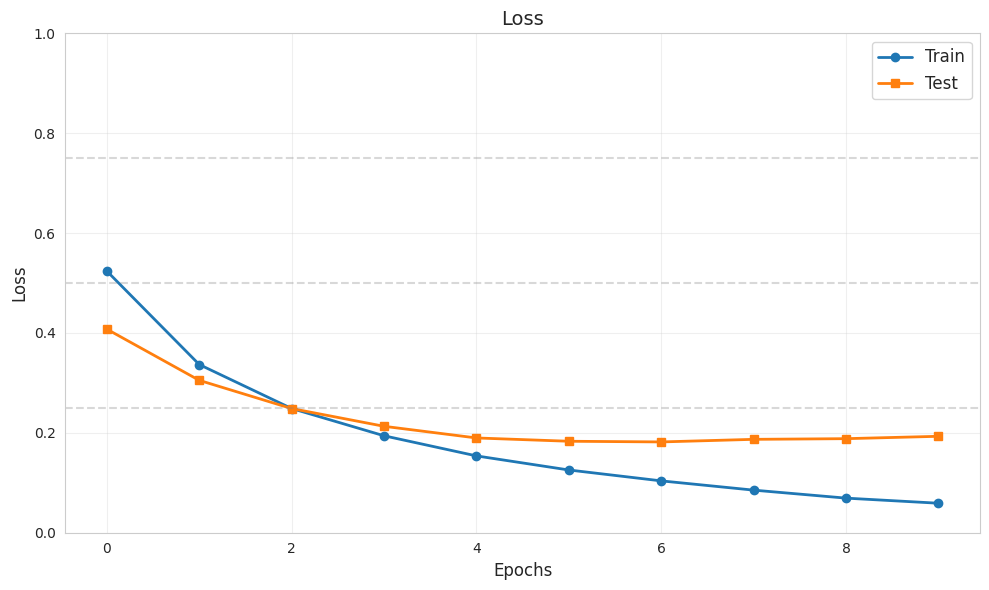

In [ ]:
plot_metrics(mean_train_loss, mean_test_loss, 'Loss')

<Figure size 640x480 with 0 Axes>

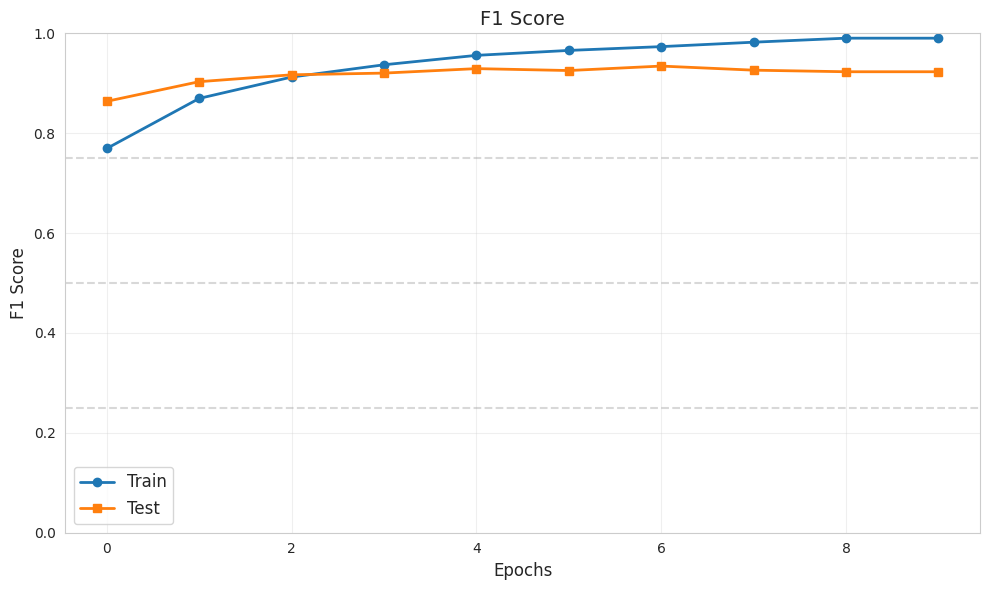

In [ ]:
plot_metrics(mean_train_f1, mean_test_f1, 'F1 Score')

<Figure size 640x480 with 0 Axes>

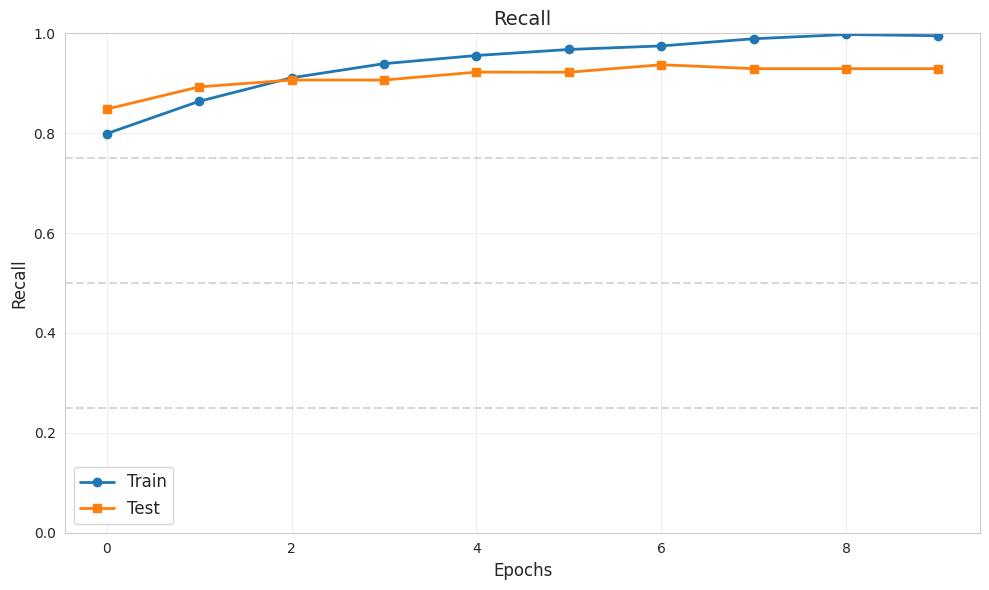

In [ ]:
plot_metrics(mean_train_recall, mean_test_recall, 'Recall')

<Figure size 640x480 with 0 Axes>

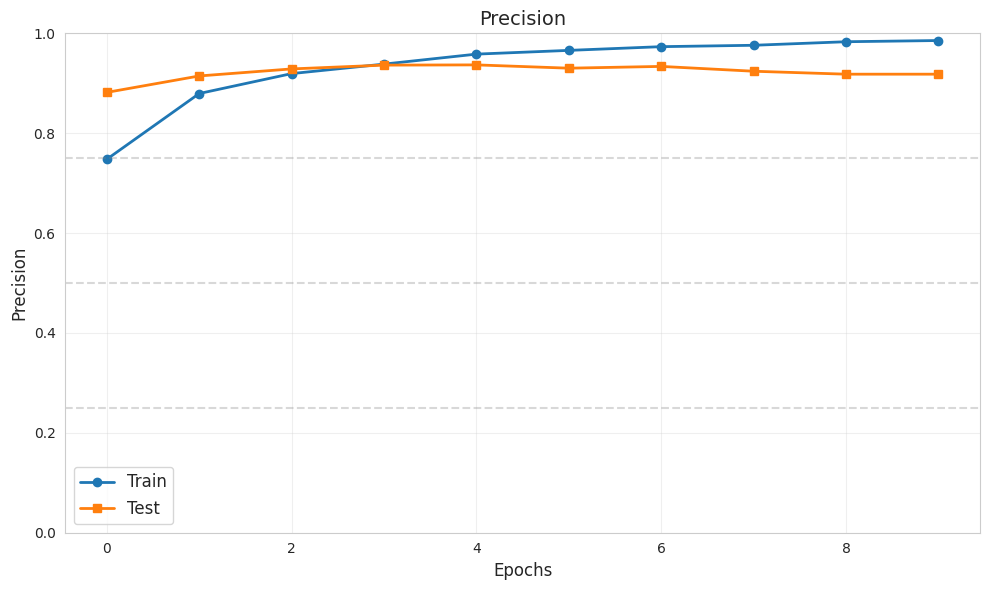

In [ ]:
plot_metrics(mean_train_precision, mean_test_precision, 'Precision')

<Figure size 640x480 with 0 Axes>

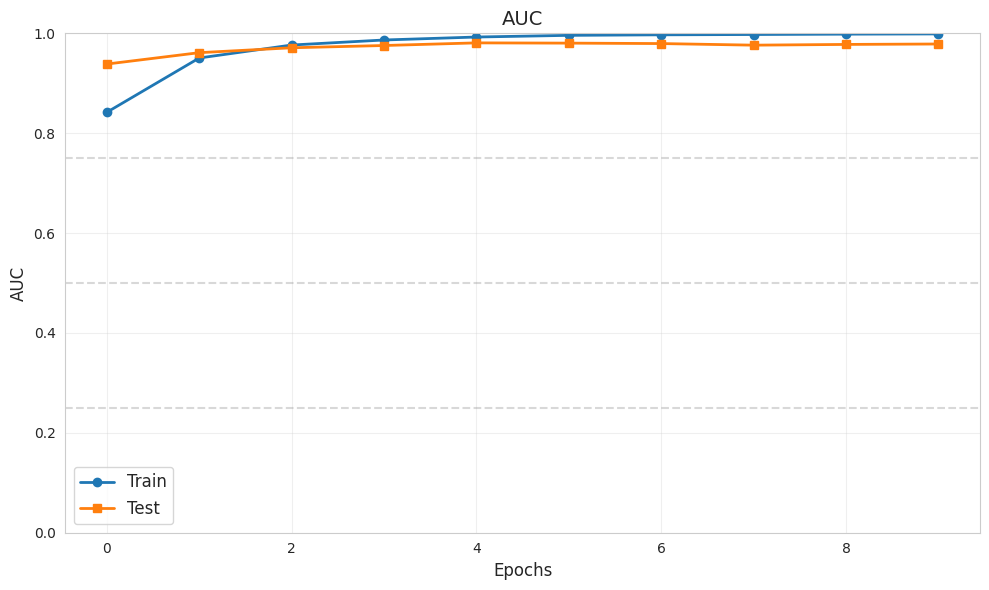

In [ ]:
plot_metrics(mean_train_auc, mean_test_auc, 'AUC')

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1O0S5tEUBHZaynn1L8a5KSwXLLiYimW5g"></center>

<center>👉👉 <a href="https://forms.gle/H7v5qZbBuiHvMbBu9">Click here to participate in the poll</a>👈👈</center>

## Feature Importance

Using the trained model `fm` and the feature data `X_num_train`, `X_cat_train`, `X_num_test` and `X_cat_test`, We would like to create a bar plot visualizing the feature importance for both training and testing data.

---
<font color=green>Q24:</font>
<br><font color='green'>
Make predictions using the model `fm` on both the training and testing data. The model returns two outputs: the predicted values and the importance weights (alpha) for each feature.

</font>

---









In [ ]:
train_inputs = (tf.cast(X_num_train, dtype=tf.float32), tf.cast(X_cat_train, dtype=tf.int32))
test_inputs = (tf.cast(X_num_test, dtype=tf.float32), tf.cast(X_cat_test, dtype=tf.int32))
train_predictions, alpha_train = fm(train_inputs)
test_predictions, alpha_test = fm(test_inputs)

---
<font color=green>Q25:</font>
<br><font color='green'>
Compute the mean feature importance for both training and testing data by averaging the importance weight associated with each feature (numerical or categorical).

</font>

---



In [ ]:
feature_importance_train = tf.reduce_mean(alpha_train, axis=0).numpy()
feature_importance_test = tf.reduce_mean(alpha_test, axis=0).numpy()

---
<font color=green>Q26:</font>
<br><font color='green'>
Create a horizontal bar plot showing the feature importance of each feature for both the training and testing data. Use different colors to distinguish between the training and testing data. The y-axis should represent the features. The x-axis should represent the feature importance. Include a legend to distinguish between the training and testing data.

</font>

---



In [ ]:
def plot_feature_importance(X_num, X_cat, feature_importance_train, feature_importance_test):
    """
    Plot feature importance for train and test sets in descending order.

    Parameters:
    -----------
    X_num : pandas DataFrame
        Numerical features dataframe
    X_cat : pandas DataFrame
        Categorical features dataframe
    feature_importance_train : array-like
        Feature importance values for training set
    feature_importance_test : array-like
        Feature importance values for test set
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Get all feature names
    list_features = list(X_num.columns) + list(X_cat.columns)

    # Create data structure for sorting
    combined_data = list(zip(list_features, feature_importance_train, feature_importance_test))

    # Sort by the average importance (train+test) in descending order
    sorted_data = sorted(combined_data, key=lambda x: (x[1] + x[2])/2, reverse=False)

    # Unpack the sorted data
    sorted_features, sorted_importance_train, sorted_importance_test = zip(*sorted_data)

    plt.clf()
    plt.figure(figsize=(10, 6))

    # Plot the horizontal bars
    y_positions = np.arange(len(sorted_features))
    bar_width = 0.35

    # Plot sorted bars
    plt.barh(y_positions - bar_width/2, sorted_importance_train, height=bar_width,
             label='Train', color='#3498db', alpha=0.8)
    plt.barh(y_positions + bar_width/2, sorted_importance_test, height=bar_width,
             label='Test', color='#e74c3c', alpha=0.8)

    # Set the y-axis tick labels with sorted features
    plt.yticks(y_positions, sorted_features)

    # Add grid lines for readability
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # Add labels and legend
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.legend(fontsize=12)
    plt.title('Feature Importance Comparison (Train vs Test)', fontsize=14)

    # Adjust layout
    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

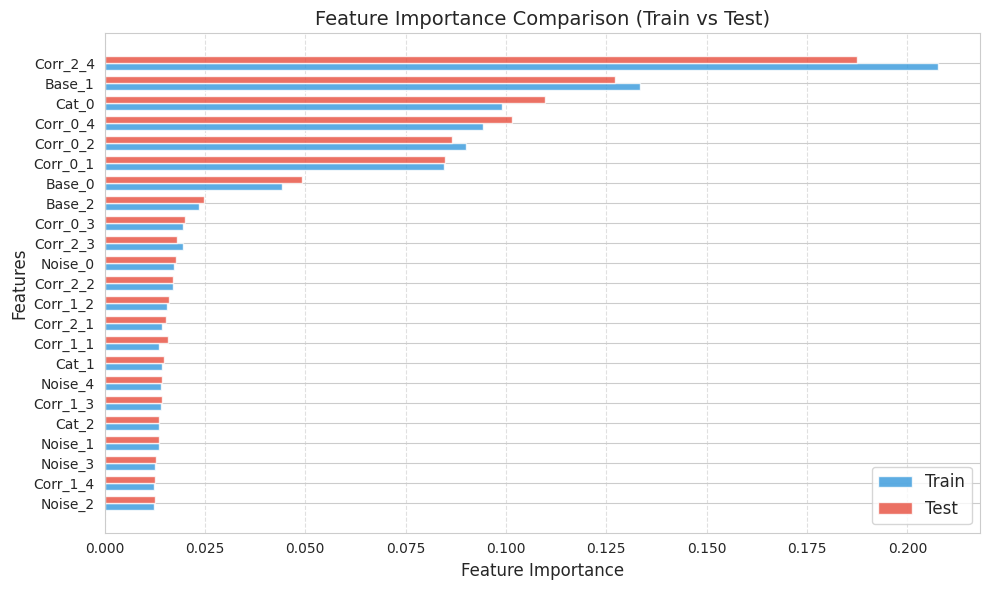

In [ ]:
# After training your model and getting feature importances
plot_feature_importance(
    X_num,
    X_cat,
    feature_importance_train,
    feature_importance_test
)

## Conclusion

The Variable Selection Network presented in this implementation offers a powerful approach to handling both numerical and categorical data through specialized embedding techniques. By leveraging the InputTransformation Layer and Gated Residual Network architecture, the model effectively transforms raw inputs into meaningful representations while maintaining interpretability.

The core strength of this architecture lies in its gated linear units, which allow the network to adaptively focus on the most relevant features during training.

The implementation demonstrates a structured approach to deep learning model development, from data preparation and encoding to model instantiation and training. The custom training loop with comprehensive metrics tracking allows for fine-grained control over the learning process while monitoring performance across multiple dimensions.

As demonstrated in the feature importance analysis, this architecture successfully bridges the gap between predictive power and interpretability, making it particularly suitable for domains requiring transparent AI decision-making such as finance, healthcare, etc.

### Contact

If you have any question regarding this notebook, do not hesitate to contact: h.madmoun@imperial.ac.uk